# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [98]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [99]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



   lp__  accept_stat__       mu    sigma  mu_pred  sigma_pred  height_pred
0   0.0            0.0  144.933  2.45943  165.755    14.68170      147.076
1   0.0            0.0  144.933  2.45943  171.276     8.05289      173.258
2   0.0            0.0  144.933  2.45943  181.987    26.32670      207.546
3   0.0            0.0  144.933  2.45943  175.554    17.99470      175.157
4   0.0            0.0  144.933  2.45943  183.120    13.28940      178.986


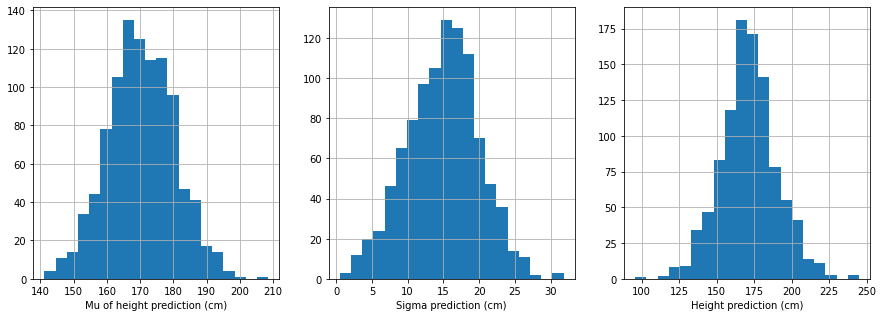

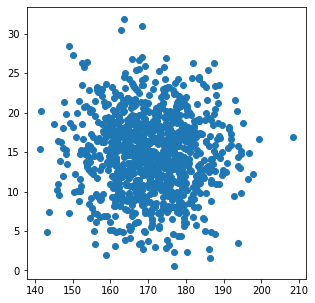

In [100]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

mu_pred = sim.stan_variable('mu_pred')
sigma_pred = sim.stan_variable('sigma_pred')
height_pred = sim.stan_variable('height_pred')

df = sim.draws_pd() # convert to dataframe
print(df.head())

# 1. Plot histograms of mu, sigma and simulated height.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
df['mu_pred'].hist(ax=axs[0], bins=20)
axs[0].set_xlabel('Mu of height prediction (cm)')
df['sigma_pred'].hist(ax=axs[1], bins=20)
axs[1].set_xlabel('Sigma prediction (cm)')
df['height_pred'].hist(ax=axs[2], bins=20)
axs[2].set_xlabel('Height prediction (cm)')
plt.show()

# 2. Plot a joint distribution of mu and sigma.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df['mu_pred'], df['sigma_pred'])
plt.show()

Mean mu:  170.35 cm
Prior mu:  170.00 cm


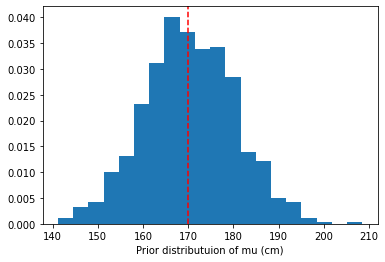

Mean sigma:  14.91 cm
Prior sigma:  15.00 cm


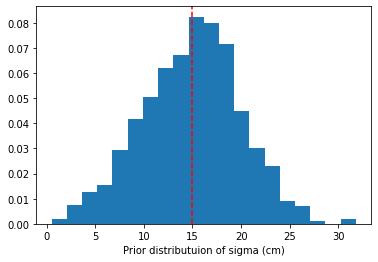

Mean height:  171.47 cm


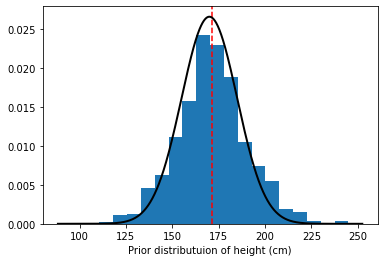

Percent of observed height samples within +/- 1 sigma:  61.00 %
Percent of observed height samples within +/- 2 sigma:  87.80 %
Percent of observed height samples within +/- 3 sigma:  97.40 %


In [101]:
from scipy.stats import norm
# 3. Check if samples are consistent with priors.
# 4. Correct prior parameters to make them reasonably spreaded out.
prior_mu = 170
mean_mu = df['mu_pred'].mean()
print("Mean mu: ", "{:.2f}".format(mean_mu), "cm")
print("Prior mu: ", "{:.2f}".format(prior_mu), "cm")

plt.hist(df['mu_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of mu (cm)')
plt.axvline(x=prior_mu, color='r', linestyle='--')
plt.show()

prior_sigma = 15
mean_sigma = df['sigma_pred'].mean()
print("Mean sigma: ", "{:.2f}".format(mean_sigma), "cm")
print("Prior sigma: ", "{:.2f}".format(prior_sigma), "cm")

plt.hist(df['sigma_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of sigma (cm)')
plt.axvline(x=prior_sigma, color='r', linestyle='--')
plt.show()

mean_height = df['height_pred'].mean()
print("Mean height: ", "{:.2f}".format(mean_height), "cm")

plt.hist(df['height_pred'], bins=20, density=True)
plt.xlabel('Prior distributuion of height (cm)')
plt.axvline(x=mean_height, color='r', linestyle='--')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, prior_mu, prior_sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.show()

# 5. Check if observed data is possible to obtain using priors.
percent_sigma_1 = len(df[(df['height_pred'] >= prior_mu - prior_sigma) & (df['height_pred'] <= prior_mu + prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 1 sigma: ", "{:.2f}".format(percent_sigma_1 * 100), "%")

percent_sigma_2 = len(df[(df['height_pred'] >= prior_mu - 2 * prior_sigma) & (df['height_pred'] <= prior_mu + 2 * prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 2 sigma: ", "{:.2f}".format(percent_sigma_2 * 100), "%")

percent_sigma_3 = len(df[(df['height_pred'] >= prior_mu - 3 * prior_sigma) & (df['height_pred'] <= prior_mu + 3 * prior_sigma)]) / len(df)
print("Percent of observed height samples within +/- 3 sigma: ", "{:.2f}".format(percent_sigma_3 * 100), "%")



1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [102]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_1_fit.stan to exe file /usr/data-analytics-lectures/Data Analytics/Lab 4/height_1_fit
INFO:cmdstanpy:compiled model executable: /usr/data-analytics-lectures/Data Analytics/Lab 4/height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmpolgy8mmi/tmphq1p48f1.hpp /tmp/tmpolgy8mmi/tmphq1p48f1.stan
Warning in '/tmp/tmpolgy8mmi/tmphq1p48f1.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/tmpolgy8mmi/tmphq1p48f1.stan', line 21, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



      lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  divergent__  \
0 -893.827       0.908870    0.855582          2.0           3.0          0.0   
1 -893.629       1.000000    0.855582          1.0           1.0          0.0   
2 -893.084       0.913313    0.855582          2.0           3.0          0.0   
3 -893.919       0.904892    0.855582          2.0           3.0          0.0   
4 -893.817       0.987014    0.855582          3.0           7.0          0.0   

   energy__       mu    sigma  height_sim[1]  ...  height_sim[343]  \
0   894.012  154.882  7.43366        141.720  ...          167.289   
1   893.873  154.882  7.48283        144.117  ...          149.294   
2   894.703  154.385  7.78943        164.396  ...          150.228   
3   894.066  154.076  7.63743        159.768  ...          164.129   
4   894.865  154.068  7.79895        158.915  ...          145.289   

   height_sim[344]  height_sim[345]  height_sim[346]  height_sim[347]  \
0          155.225

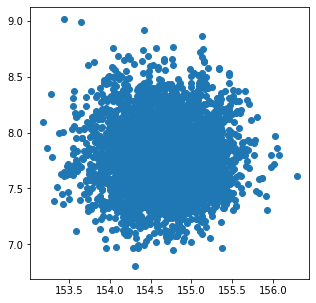

KeyError: 'heights'

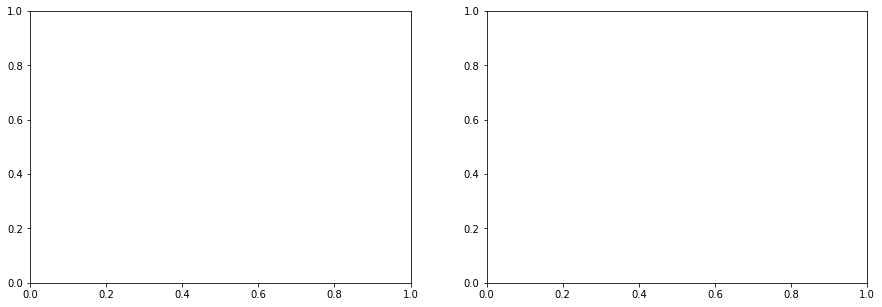

In [105]:
fit=model_1_fit.sample(data=dict(N=len(d), heights=d.height.values), seed=28052020)

df_fit = fit.draws_pd() # convert to dataframe
print(df_fit.head())

# 1. Plot a joint distribution of fitted mu and sigma.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_fit['mu'], df_fit['sigma'])
plt.show()

# 2. Plot histograms of data and simulated heights and evaluate the quality of model.
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
df_fit['heights'].hist(ax=axs[0], bins=20)
axs[0].set_xlabel('Height (cm)')
df_fit['height_sim'].hist(ax=axs[1], bins=20)
axs[1].set_xlabel('Simulated height (cm)')
plt.show()



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [ ]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}


## Task 4. Prior predictive checks
 

In [ ]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [ ]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

In [ ]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

## Task 6. Fitting and evaluating model


In [ ]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [ ]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 